In [ ]:
import os
import glob
import torch
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive (Run this in Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set device for training
torch.manual_seed(42)
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
# Define dataset paths
data_dir = "/content/drive/MyDrive/Thesis/New folder/data"  # Update with your Google Drive path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [ ]:
# Load image and mask paths
train_images = sorted(glob.glob(os.path.join(train_dir, "image", "*")))
train_masks = sorted(glob.glob(os.path.join(train_dir, "mask", "*")))

test_images = sorted(glob.glob(os.path.join(test_dir, "image", "*")))
test_masks = sorted(glob.glob(os.path.join(test_dir, "mask", "*")))

In [ ]:
# Plot function and Visualizing images and masks
def plot_from_img_path(n_examples, list_img_paths, list_mask_paths):
    fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
    i = 0
    for ax in axs:
        image, mask = list_img_paths[i], list_mask_paths[i]
        image, mask = cv2.imread(image), cv2.imread(mask)
        ax[0].set_title("MRI images")
        ax[0].imshow(image)
        ax[1].set_title("Highlighted abnormality")
        ax[1].imshow(image)
        ax[1].imshow(mask, alpha=0.2)
        ax[2].imshow(mask)
        ax[2].set_title("Abnormality mask")
        i += 1

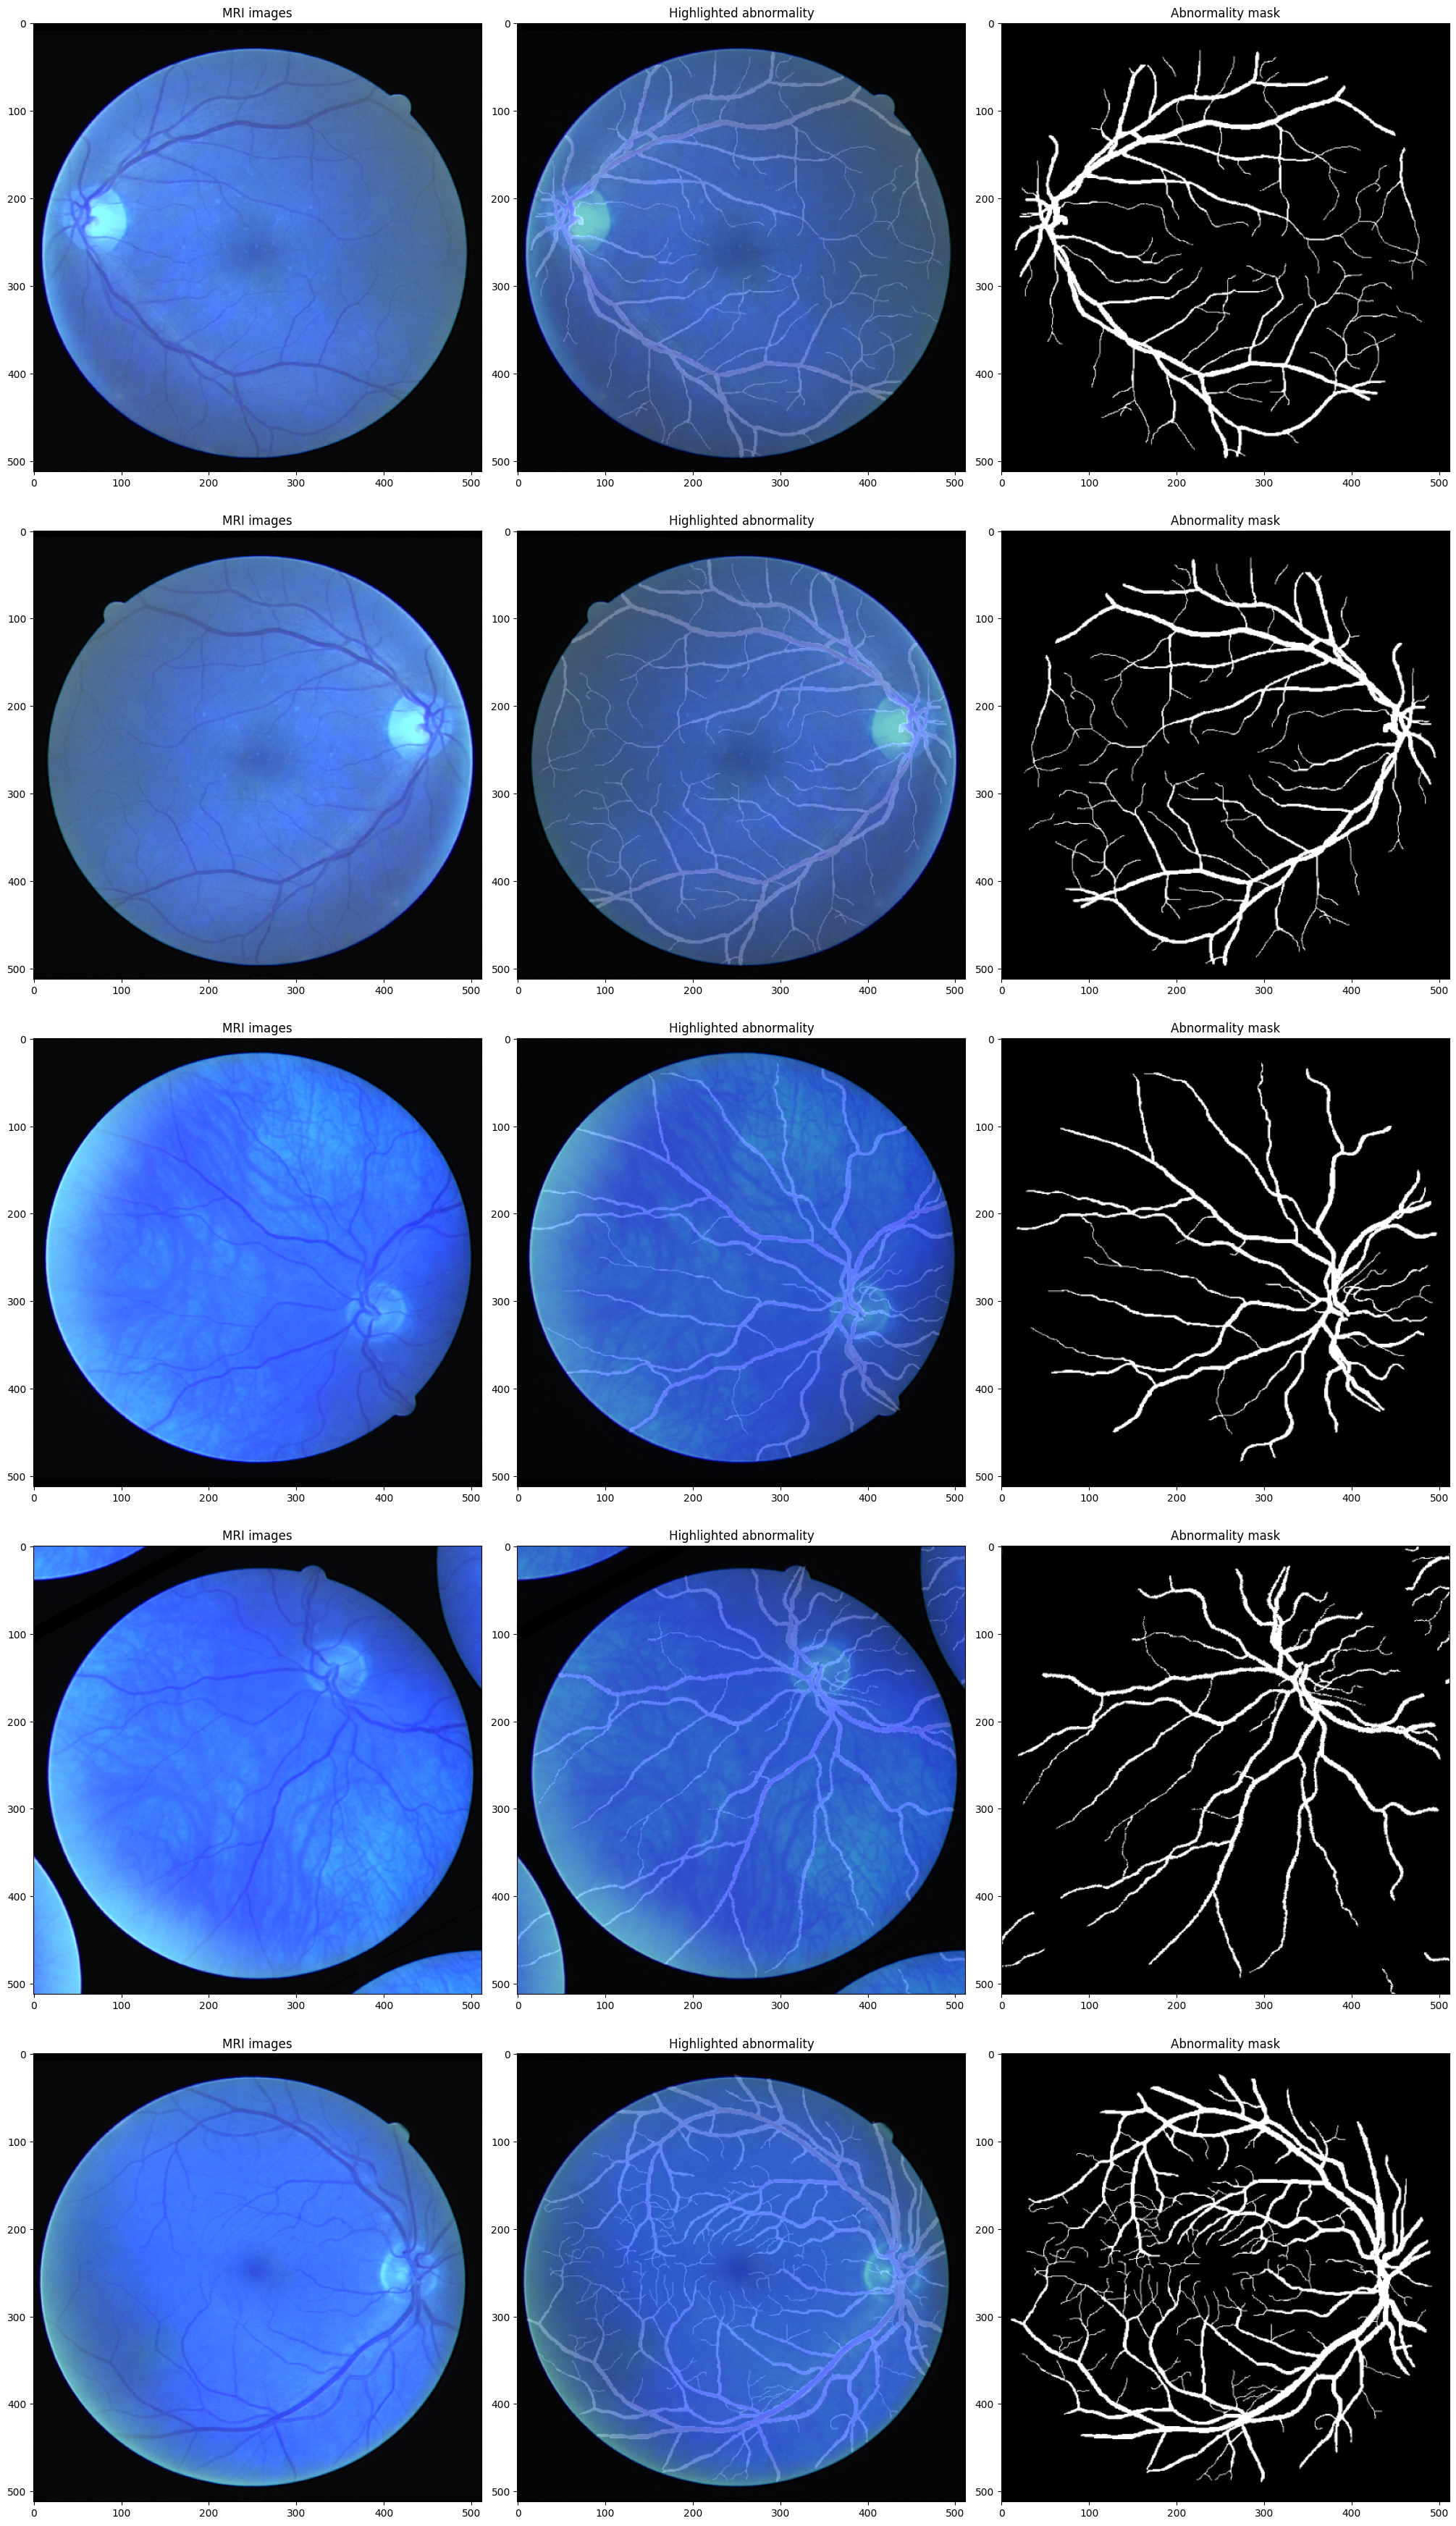

In [ ]:
plot_from_img_path(n_examples=5, list_img_paths=train_images[:5], list_mask_paths=train_masks[:5])


In [ ]:
# Create DataFrames
df = pd.DataFrame({"image": train_images + test_images, "mask": train_masks + test_masks})

In [ ]:

# Split dataset into train, val, and test sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.3, random_state=42)

print('train')
print(f"{df_train.describe().loc['count', ['image', 'mask']]}\n")
print('val')
print(f"{df_val.describe().loc['count', ['image', 'mask']]}\n")
print('test')
print(f"{df_test.describe().loc['count', ['image', 'mask']]}\n")

train
image    70
mask     70
Name: count, dtype: object

val
image    9
mask     9
Name: count, dtype: object

test
image    21
mask     21
Name: count, dtype: object



In [ ]:
# Define transformations
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])


In [ ]:
# Define Dataset class
class RetinaDataset(Dataset):
    def __init__(self, df, img_transform=None, mask_transform=None):
        self.image_paths = df["image"].tolist()
        self.mask_paths = df["mask"].tolist()
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask

In [ ]:

# Create datasets
dataset_train = RetinaDataset(df_train, img_transform, mask_transform)
dataset_val = RetinaDataset(df_val, img_transform, mask_transform)
dataset_test = RetinaDataset(df_test, img_transform, mask_transform)

In [ ]:
# Create DataLoaders
batch_size = 8
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Define Enhanced Attention Block with CBAM and Group Normalization
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=F_int),
            nn.ReLU(inplace=True)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=F_int),
            nn.ReLU(inplace=True)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        self.spatial_dropout = nn.Dropout2d(p=0.2)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(torch.relu(g1 + x1))
        psi = self.spatial_dropout(psi)
        return x * psi

In [ ]:
# Define Improved U-Net with CBAM Attention and Group Normalization
class UNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNetWithAttention, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = self._block(features * 2, features * 4)

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 4, features * 2)
        self.att2 = AttentionBlock(features * 2, features * 2, features)

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)
        self.att1 = AttentionBlock(features, features, features // 2)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
        self.cbam = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(features, features // 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features // 2, features, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_dropout = nn.Dropout2d(p=0.2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = torch.cat((self.att2(self.upconv2(bottleneck), enc2), self.upconv2(bottleneck)), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = torch.cat((self.att1(self.upconv1(dec2), enc1), self.upconv1(dec2)), dim=1)
        dec1 = self.decoder1(dec1)

        cbam_weight = self.cbam(dec1)
        dec1 = dec1 * cbam_weight  # Applying CBAM weight to refine feature maps
        return torch.sigmoid(self.conv(self.spatial_dropout(dec1)))

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=features),
            nn.ReLU(inplace=True),
        )


In [ ]:
# Training loop
def training_loop(epochs, model, train_dataloader, val_dataloader, loss_fn, optimizer):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        for data in tqdm(train_dataloader):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = loss_fn(pred, mask)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            for data in tqdm(val_dataloader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                loss = loss_fn(pred, mask)
                running_val_loss += loss.item()
        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')
    model.eval()
    return history


In [ ]:
# Define model, loss function, and optimizer
model = UNetWithAttention(in_channels=3, out_channels=1, init_features=32).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Train model
epochs = 30
history = training_loop(epochs, model, train_loader, val_loader, criterion, optimizer)

100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Epoch: 1/30 | Training loss: 0.06310170505728041 | Validation loss: 0.09598021043671502


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch: 2/30 | Training loss: 0.053337847334997995 | Validation loss: 0.08914800816112095


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Epoch: 3/30 | Training loss: 0.050103981154305595 | Validation loss: 0.08296285735236274


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch: 4/30 | Training loss: 0.04656993576458522 | Validation loss: 0.07712929447491963


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch: 5/30 | Training loss: 0.04402732806546347 | Validation loss: 0.07073236836327447


100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


Epoch: 6/30 | Training loss: 0.038920021908623835 | Validation loss: 0.06567417250739203


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch: 7/30 | Training loss: 0.0351309808237212 | Validation loss: 0.05621742539935642


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Epoch: 8/30 | Training loss: 0.03238400944641658 | Validation loss: 0.05264540182219611


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Epoch: 9/30 | Training loss: 0.028452276332037788 | Validation loss: 0.04563076463010576


100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


Epoch: 10/30 | Training loss: 0.026128825758184704 | Validation loss: 0.04282741083039178


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Epoch: 11/30 | Training loss: 0.023887893770422254 | Validation loss: 0.04070845080746545


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch: 12/30 | Training loss: 0.022778277737753733 | Validation loss: 0.03823927044868469


100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch: 13/30 | Training loss: 0.02144666910171509 | Validation loss: 0.03679839273293813


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Epoch: 14/30 | Training loss: 0.021487782256943838 | Validation loss: 0.03551792105038961


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch: 15/30 | Training loss: 0.020601406693458557 | Validation loss: 0.03510131438573202


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Epoch: 16/30 | Training loss: 0.02092099530356271 | Validation loss: 0.0355528559949663


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch: 17/30 | Training loss: 0.019748033796037946 | Validation loss: 0.034354574150509305


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Epoch: 18/30 | Training loss: 0.019964485934802465 | Validation loss: 0.03424367308616638


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch: 19/30 | Training loss: 0.019126608542033605 | Validation loss: 0.033803201384014554


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch: 20/30 | Training loss: 0.018760818030153004 | Validation loss: 0.033303257491853505


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


Epoch: 21/30 | Training loss: 0.018911432155541013 | Validation loss: 0.03300818304220835


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Epoch: 22/30 | Training loss: 0.018613028952053617 | Validation loss: 0.03295501901043786


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


Epoch: 23/30 | Training loss: 0.0181586748787335 | Validation loss: 0.03317258755366007


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Epoch: 24/30 | Training loss: 0.018124298219169888 | Validation loss: 0.032436490058898926


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


Epoch: 25/30 | Training loss: 0.018117297121456693 | Validation loss: 0.03209714260366228


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Epoch: 26/30 | Training loss: 0.018018345534801482 | Validation loss: 0.031968524058659874


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Epoch: 27/30 | Training loss: 0.017966058424540927 | Validation loss: 0.03172908226648966


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Epoch: 28/30 | Training loss: 0.017833218617098672 | Validation loss: 0.0320135106643041


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Epoch: 29/30 | Training loss: 0.017648976402623313 | Validation loss: 0.03139104280206892


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

Epoch: 30/30 | Training loss: 0.01733719536236354 | Validation loss: 0.030957129266526964


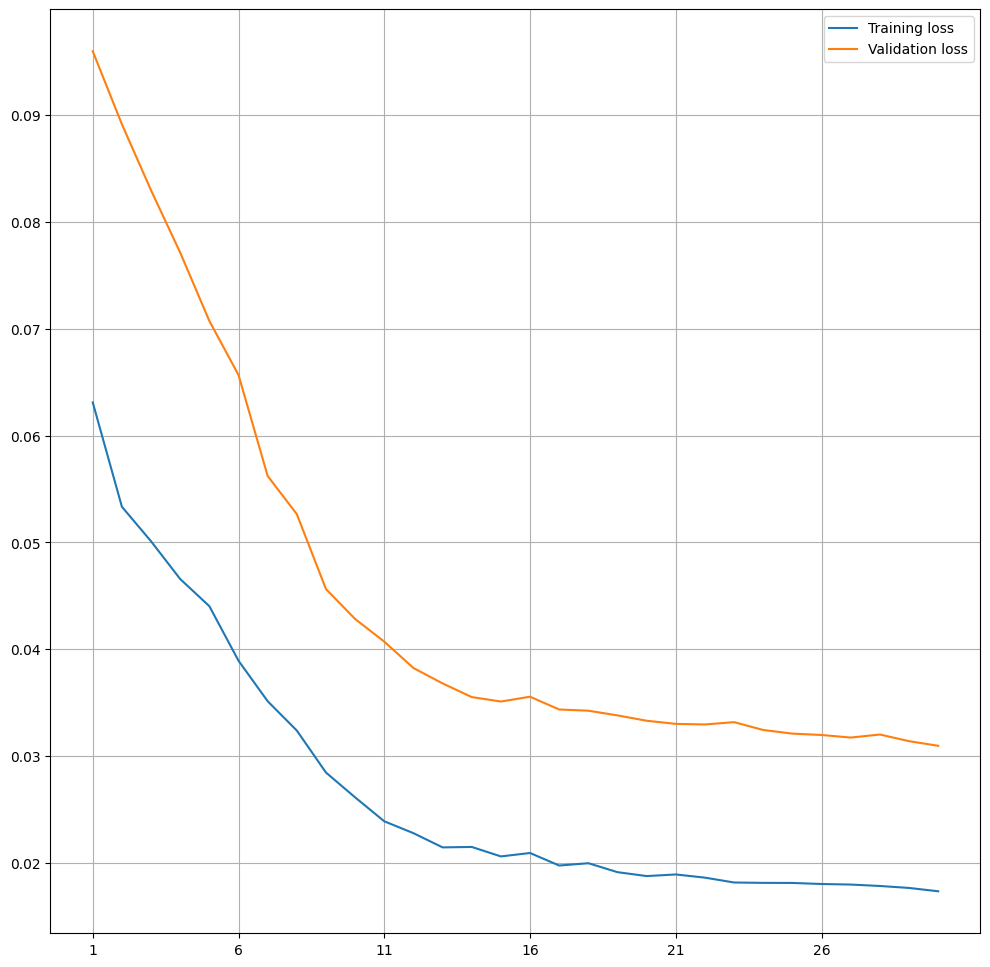

In [ ]:
# Plot training results
plt.figure(figsize=(12, 12))
plt.plot(np.arange(1, epochs+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs+1), history['val_loss'], label='Validation loss')
plt.xticks(np.arange(1, epochs+1, 5))
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Test set evaluation
def test_set_evaluation(models):
    for key, model in models.items():
        with torch.no_grad():
            running_loss = 0
            for data in test_loader:
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                loss = criterion(predictions, mask)
                running_loss += loss.item() * img.size(0)
            loss = running_loss / len(dataset_test)
            print(f'Test loss with {key}: {loss}')
test_set_evaluation({"current_model": model})

Test loss with current_model: 0.12419910587015606


In [ ]:
# Visualize segmentation results
def visualize_segmentation(model, dataloader, num_examples=1):
    model.eval()
    dataset_size = len(dataloader.dataset)
    random_indices = random.sample(range(dataset_size), num_examples)
    for idx in random_indices:
        img, mask = dataloader.dataset[idx]
        img, mask = img.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)
        with torch.no_grad():
            pred = model(img)
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask = mask.squeeze(0).squeeze(0).cpu().numpy()
        pred = pred.squeeze(0).squeeze(0).cpu().numpy()
        binary_pred = pred > 0.5
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        axes[0].imshow(img)
        axes[0].set_title('Input Image')
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('True Mask')
        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[3].imshow(binary_pred, cmap='gray')
        axes[3].set_title('Binary Predicted Mask')
        plt.show()


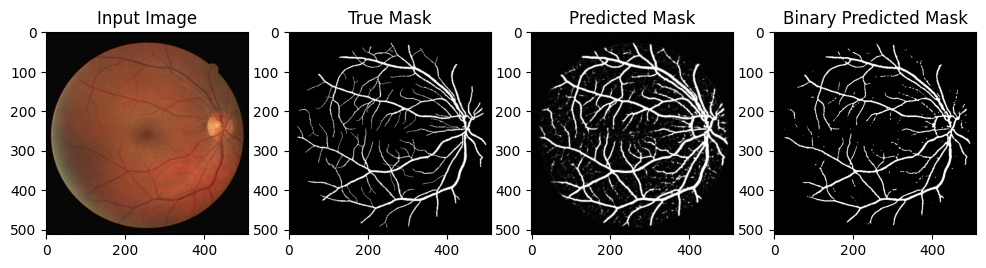

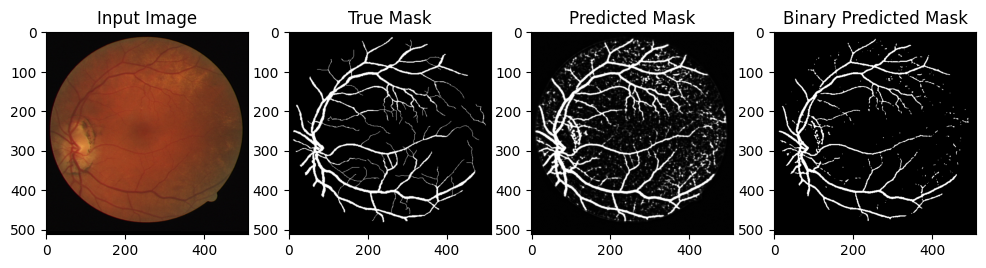

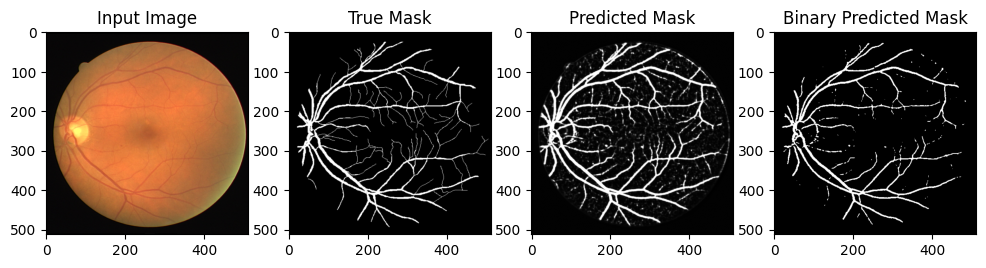

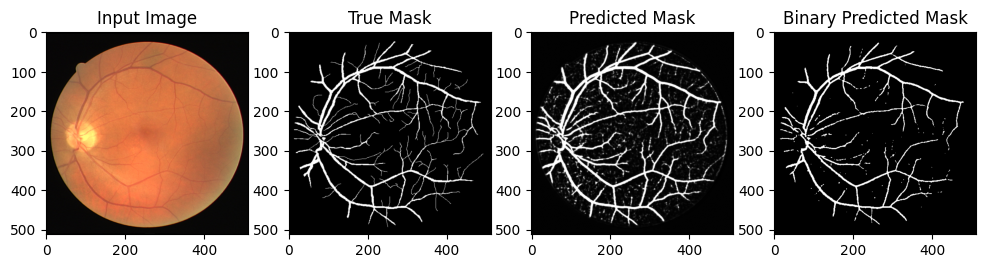

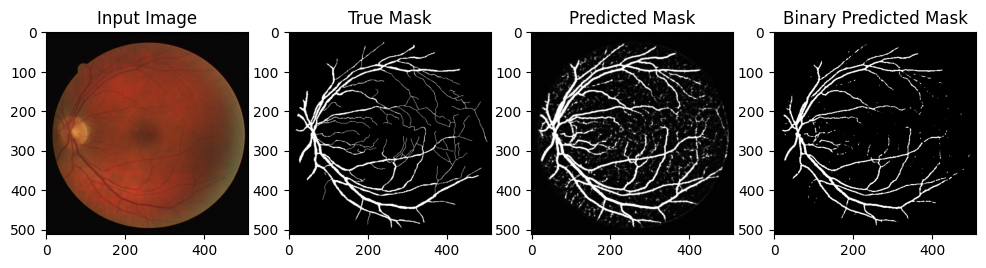

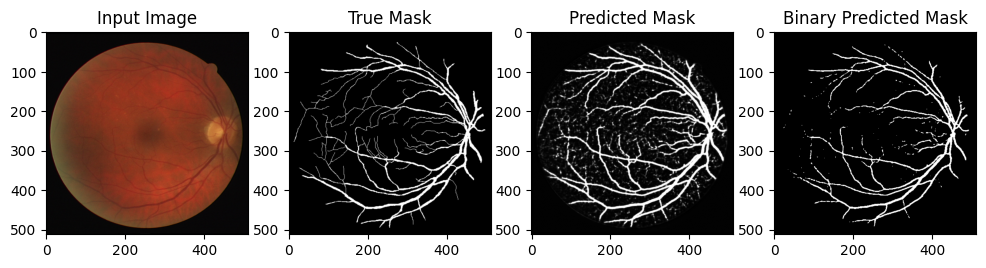

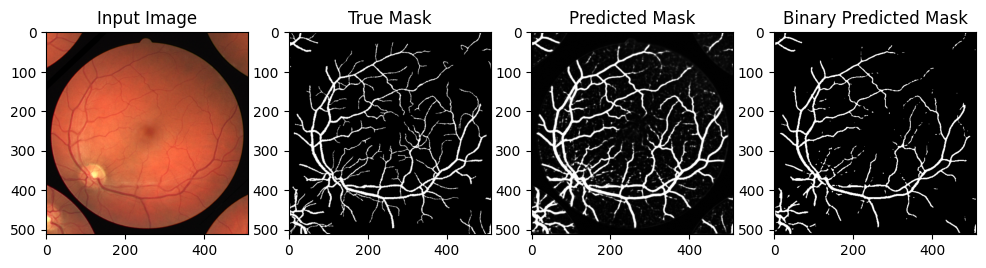

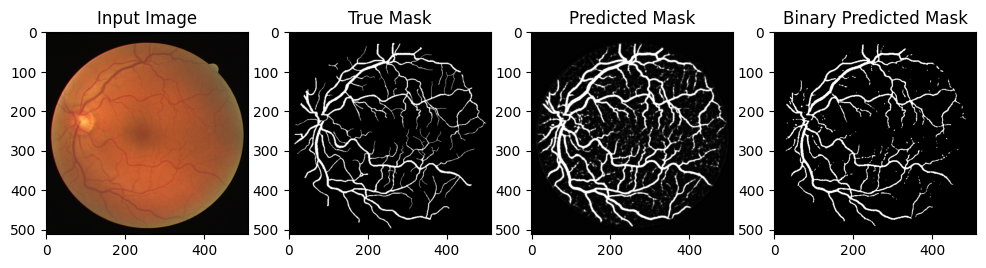

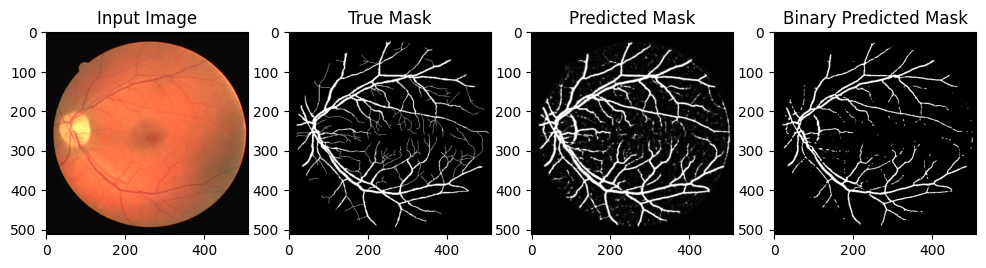

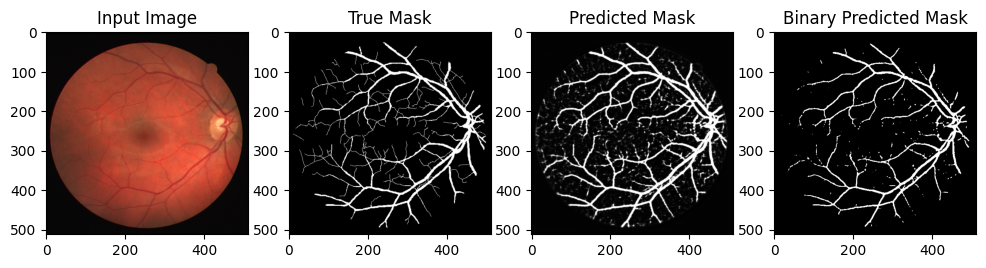

In [ ]:
visualize_segmentation(model, test_loader, 10)  # Change test_dataloader to test_loader